![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics

# Embedded fracture model for large fracture spacings

In [1]:
#HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import plot_settings
import seaborn as sns #für Farb en
plt.rcParams.update({'font.size': 16})

In [2]:
km = 1e-20

In [3]:
b0 = np.sqrt(12.*km)

In [4]:
b = lambda en, a, e0: b0 + a*np.heaviside(en-e0,0)*(en-e0)

In [5]:
k = lambda en, a, e0: km + b(en,a,e0)/a * (b(en,a,e0)**2/12 - km)
dkde = lambda en,a,e0: (b(en,a,e0)**2/4 - km)*np.heaviside(en-e0,0)
dkde_n = lambda en,a,e0: (k(en+en/1e8,a,e0)-k(en-en/1e8,a,e0))/(2*en/1e8)

In [6]:
a_vals = np.array([0.0001,0.001,0.01,0.1,1,10])

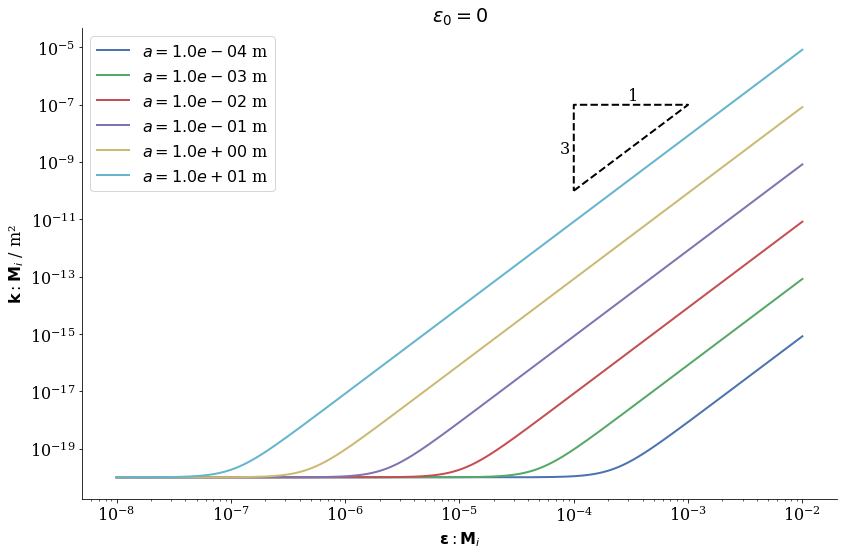

In [7]:
#HIDDEN
eps_n = np.logspace(-8,-2,1000)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([1e-4,1e-3,1e-4,1e-4],[1e-10,1e-7,1e-7,1e-10],color='black',ls='--')
ax.text(7.5e-5,2e-9,'3')
ax.text(3e-4,1.5e-7,'1')
for v in a_vals:
    ax.plot(eps_n,k(eps_n,v,0),label='$a= %.1e$ m' %v)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\mathbf{k} : \\mathbf{M}_i$ / m²')
ax.set_xlabel('${\\bf{\\epsilon}} : \\mathbf{M}_i$')
ax.set_title('$\\epsilon_0 = 0$')
fig.tight_layout();
fig.savefig('permeability_model.pdf')

### So what's happening ... 

\begin{align}
    \mathbf{k} : \mathbf{M}_i &= k_\mathrm{m} + \frac{b}{a} \left( \frac{b^2}{12} - k_\mathrm{m} \right)
    \\
    b &= b_0 + a \langle \epsilon_\mathrm{n} - \epsilon_0 \rangle \quad \mathrm{with} \quad b_0 = \sqrt{12 k_\mathrm{m}} \ , \quad \epsilon_\mathrm{n} = \boldsymbol{\epsilon} : \mathbf{M}_i
\end{align}

We see in the plot above, that the model works also for large $a$. However, the nonlinearity increases drastically (significant permeability changes at extremely small strains). That's a consequence of the power-law structure of the model.

The linearization in the Jacobian matrix is not implemented in OGS. In most cases (small $a$), this does not hinder convergence. For high values of $a$, this term may have to be added.

From the last statement we can extract

$$
    \Delta b = a \langle \epsilon_\mathrm{n} - \epsilon_0 \rangle
$$

If $a$ is the element size $h_\text{el}$ divided by some number (of fractures per element) $n_\text{f,el}$, then each fracture opens by $\Delta b = h_\text{el}/n_\text{f,el} \epsilon_\text{n}$, and all fractures in the element amount to the length change of the element: $\Delta h = \sum \Delta b = h_\text{el} \epsilon_\text{n}$. That's consistent with the microstructure interpretation of the model.

### Large fracture spacings

Now, let's assume $k_\mathrm{m} = 0$ and $b_0 = 0$, so that

$$
    k = \frac{b^3}{12a} = \frac{a^2 \epsilon_\mathrm{n}^3}{12}
$$

Let's further assume we now mesh a single fracture with multiple elements across its thickness. Thus, a homogeneously stretched layer of thickness $h$ divided into $n$ elements of size $h_\text{el} = h/n$ is experiencing a given normal strain. Now we integrate over the entire layer (small strains) and get a transmissibility of

$$
    T = \int \limits_0^h k\, \text{d}z = \frac{b^3 h}{12 a}
$$

Thus, to recover the cubic law, we find (for this particular case) $a = h$, and thus $\Delta b = b = h \epsilon_\text{n}$. Thus, each element extrapolates the length change based on the strain it experiences to the entire layer's thickness and calculates the fractures total aperture (change).

### Influence of $\epsilon_0$

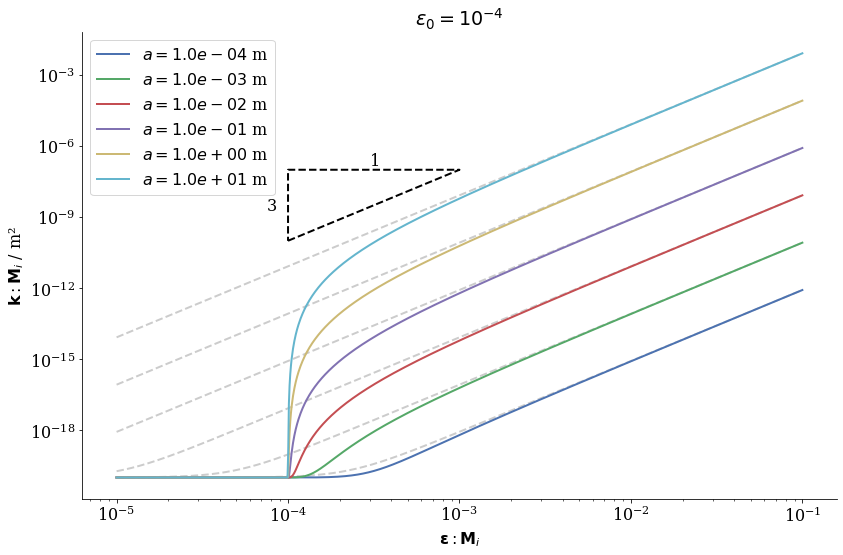

In [8]:
#HIDDEN
eps_n = np.logspace(-5,-1,1000)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([1e-4,1e-3,1e-4,1e-4],[1e-10,1e-7,1e-7,1e-10],color='black',ls='--')
ax.text(7.5e-5,2e-9,'3')
ax.text(3e-4,1.5e-7,'1')
for v in a_vals:
    ax.plot(eps_n,k(eps_n,v,0),ls='--',color='black',alpha=0.2)
    ax.plot(eps_n,k(eps_n,v,1e-4),label='$a= %.1e$ m' %v)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\mathbf{k} : \\mathbf{M}_i$ / m²')
ax.set_xlabel('${\\bf{\\epsilon}} : \\mathbf{M}_i$')
ax.set_title('$\\epsilon_0 = 10^{-4}$')
fig.tight_layout();
fig.savefig('permeability_model2.pdf')

We see a very sharp increase to the cubic law when positive values for $\epsilon_0$ are used.

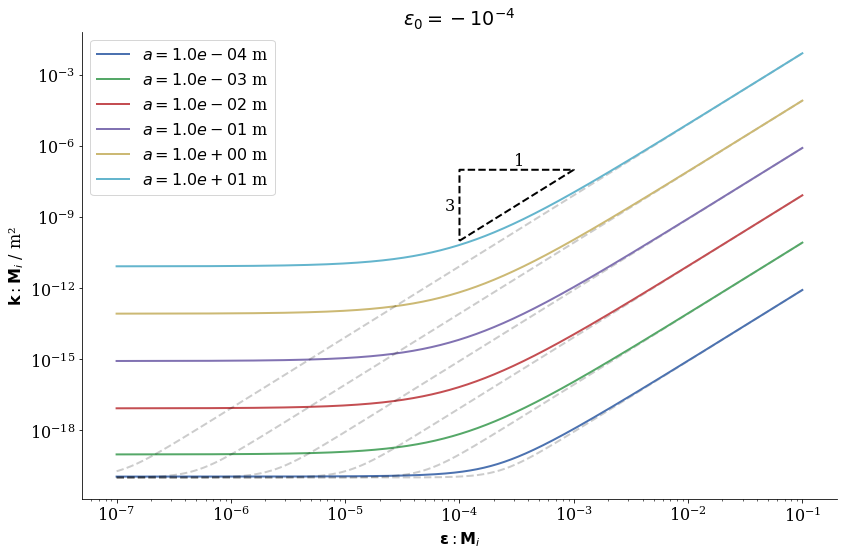

In [9]:
#HIDDEN
eps_n = np.logspace(-7,-1,1000)
fig, ax = plt.subplots(figsize=(12,8))
ax.plot([1e-4,1e-3,1e-4,1e-4],[1e-10,1e-7,1e-7,1e-10],color='black',ls='--')
ax.text(7.5e-5,2e-9,'3')
ax.text(3e-4,1.5e-7,'1')
for v in a_vals:
    ax.plot(eps_n,k(eps_n,v,0),ls='--',color='black',alpha=0.2)
    ax.plot(eps_n,k(eps_n,v,-1e-4),label='$a= %.1e$ m' %v)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\mathbf{k} : \\mathbf{M}_i$ / m²')
ax.set_xlabel('${\\bf{\\epsilon}} : \\mathbf{M}_i$')
ax.set_title('$\\epsilon_0 = -10^{-4}$')
fig.tight_layout();
fig.savefig('permeability_model3.pdf')

When a negative $\epsilon_0$ is chosen, the model has a higher initial permeability than given by $k_\text{m}$ and non-linearity is moderate.

### Derivatives

Numerically computed derivatives (central differences) are in black dotted lines, analytical ones in colored solid lines.

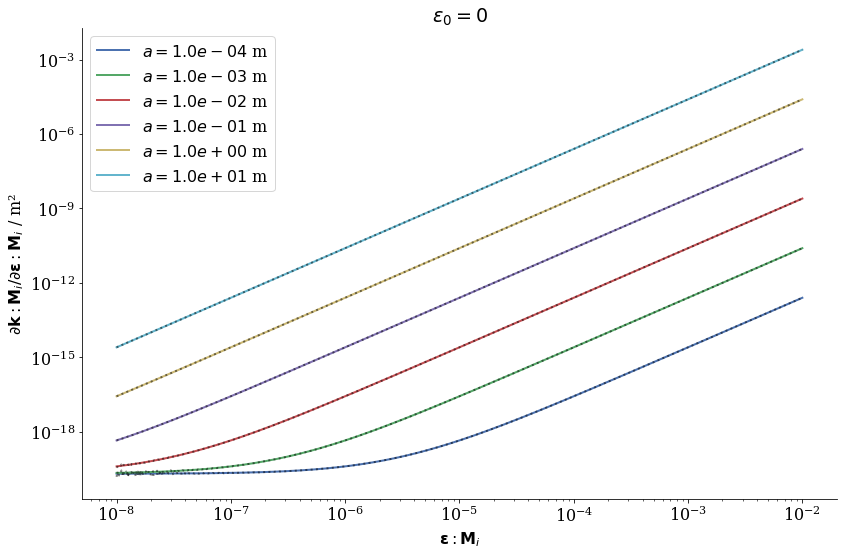

In [10]:
#HIDDEN
eps_n = np.logspace(-8,-2,1000)
fig, ax = plt.subplots(figsize=(12,8))
for v in a_vals:
    ax.plot(eps_n,dkde(eps_n,v,0),label='$a= %.1e$ m' %v)
    ax.plot(eps_n,dkde_n(eps_n,v,0),ls=':',color='black',alpha=0.5)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\partial \\mathbf{k} : \\mathbf{M}_i / \\partial {\\bf{\\epsilon}} : \\mathbf{M}_i$ / m²')
ax.set_xlabel('${\\bf{\\epsilon}} : \\mathbf{M}_i$')
ax.set_title('$\\epsilon_0 = 0$')
fig.tight_layout();

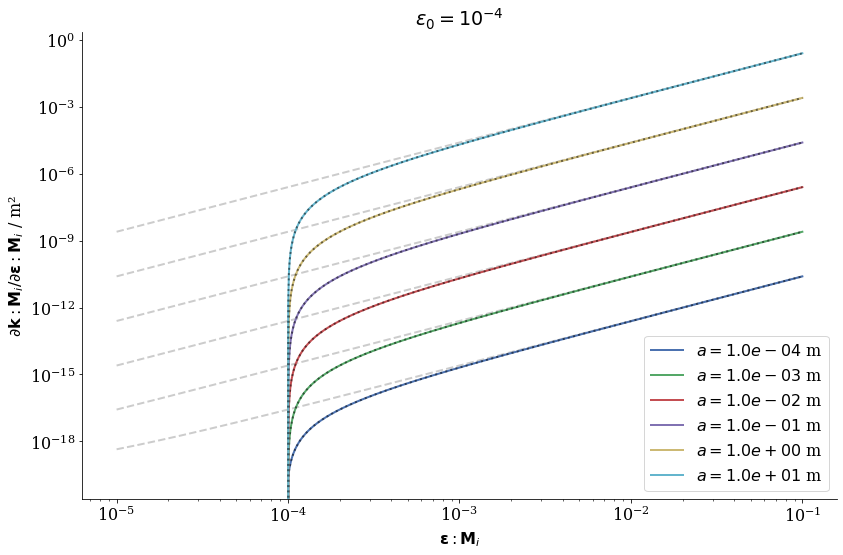

In [11]:
#HIDDEN
eps_n = np.logspace(-5,-1,1000)
fig, ax = plt.subplots(figsize=(12,8))
for v in a_vals:
    ax.plot(eps_n,dkde(eps_n,v,0),ls='--',color='black',alpha=0.2)
    ax.plot(eps_n,dkde(eps_n,v,1e-4),label='$a= %.1e$ m' %v)
    ax.plot(eps_n,dkde_n(eps_n,v,1e-4),ls=':',color='black',alpha=0.5)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\partial \\mathbf{k} : \\mathbf{M}_i / \\partial {\\bf{\\epsilon}} : \\mathbf{M}_i$ / m²')
ax.set_xlabel('${\\bf{\\epsilon}} : \\mathbf{M}_i$')
ax.set_title('$\\epsilon_0 = 10^{-4}$')
fig.tight_layout();

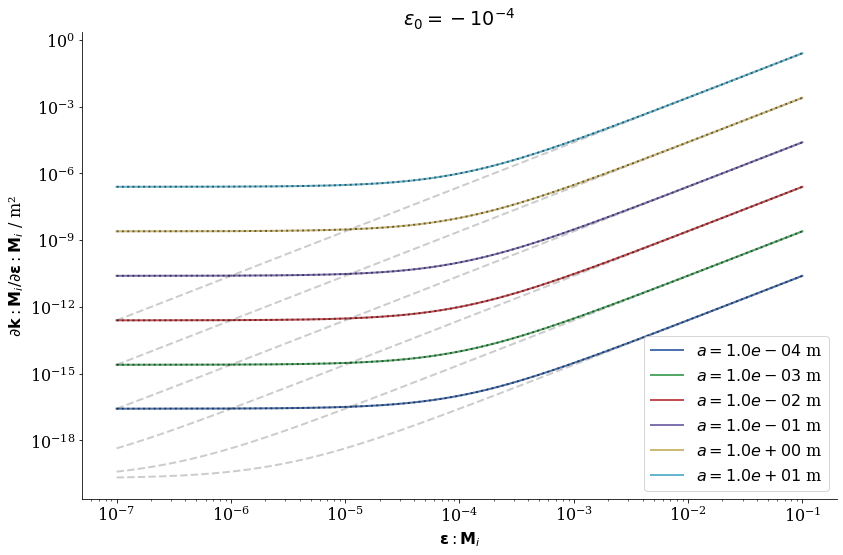

In [12]:
#HIDDEN
eps_n = np.logspace(-7,-1,1000)
fig, ax = plt.subplots(figsize=(12,8))
for v in a_vals:
    ax.plot(eps_n,dkde(eps_n,v,0),ls='--',color='black',alpha=0.2)
    ax.plot(eps_n,dkde(eps_n,v,-1e-4),label='$a= %.1e$ m' %v)
    ax.plot(eps_n,dkde_n(eps_n,v,-1e-4),ls=':',color='black',alpha=0.5)
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('$\\partial \\mathbf{k} : \\mathbf{M}_i / \\partial {\\bf{\\epsilon}} : \\mathbf{M}_i$ / m²')
ax.set_xlabel('${\\bf{\\epsilon}} : \\mathbf{M}_i$')
ax.set_title('$\\epsilon_0 = -10^{-4}$')
fig.tight_layout();